In [325]:
# import python packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib magic command to make sure plots appear inline
%matplotlib inline

# set seaborn colour codes and palette
sns.set(color_codes=True)
sns.set_palette("Set2");

#set figure size
plt.rcParams['figure.figsize'] = [15, 4]

# Real World Data

In [326]:
# imported csv 
pl = pd.read_csv("league_table.csv", index_col="Team", names=["Team", "Home(F)", "Home(A)", "Points(H)", "Away(F)", "Away(A)", "Points(A)" ]);

This notebook will explored the goals scored, and points gained, by premier league team at home and away from home, over the course of a season. The dataset used is an existing dataset that I had created based on the results of the last Premier League season.

Teams' performance at home tends to be better than their performance away from from. Initial analysis will be carried out on the dataset, examining the goals scored and conceded, goal difference, and points gained at home and away from home.

When that analysis has been completed random data will be generated, using the numpy package, to simulate a league table with those variables.

In [327]:
# added new column of total goals scored
pl["Total(F)"] = pl["Home(F)"] + pl["Away(F)"]
# added new column of total goals conceded
pl["Total(A)"] = pl["Home(A)"] + pl["Away(A)"]
# added new column of difference between goals scored and conceded
pl["Total(Dif)"]= pl["Total(F)"] - pl["Total(A)"]
# added new column with total points
pl["Total(P)"] = pl["Points(H)"] + pl["Points(A)"]

# created datafram with total goals for, against, difference, and total points
total=pl[["Total(F)", "Total(A)", "Total(Dif)", "Total(P)"]]
total

,Total(F),Total(A),Total(Dif),Total(P)
Team,,,,
Manchester City,95,23,72,98
Liverpool,89,22,67,97
Chelsea,63,39,24,72
Tottenham,67,39,28,71
Arsenal,73,51,22,70
Manchester United,65,54,11,66
Wolves,47,46,1,57
Everton,54,46,8,54
Leicester City,51,48,3,52


The original dataset only contains data seperated by home and away tables. As such, a combined dataframe was created. This dataframe will used as a reference point for the randomly generated league table.

In [328]:
total.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,53.600000,53.600000,0.000000,53.450000
std,18.071204,15.752694,32.371202,21.007455
min,22.000000,22.000000,-54.000000,16.000000
25%,44.250000,46.000000,-20.750000,39.750000
50%,51.500000,53.500000,-2.500000,51.000000
75%,63.500000,65.750000,13.750000,67.000000
max,95.000000,81.000000,72.000000,98.000000


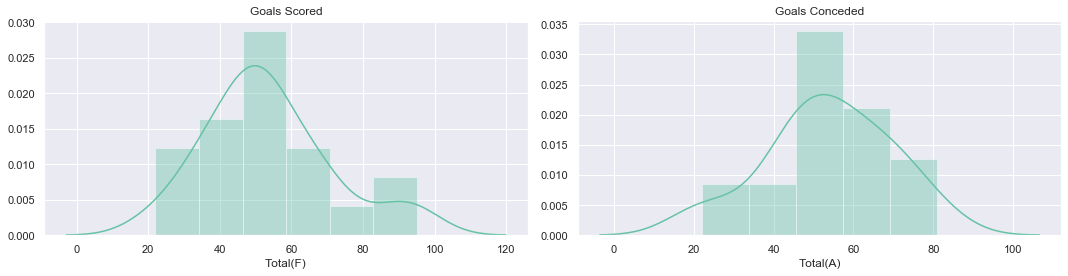

In [329]:
# distibution of goals scored at home across the league
plt.subplot(1,2,1)
sns.distplot(total["Total(F)"])
plt.title("Goals Scored");

# distribution of goals conceded at home across the league
plt.subplot(1,2,2)
sns.distplot(total["Total(A)"])
plt.title("Goals Conceded");

plt.tight_layout()

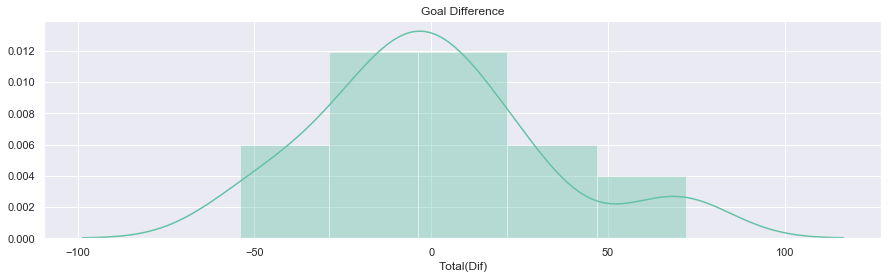

In [330]:
# distribution of goal difference
sns.distplot(total["Total(Dif)"])
plt.title("Goal Difference");

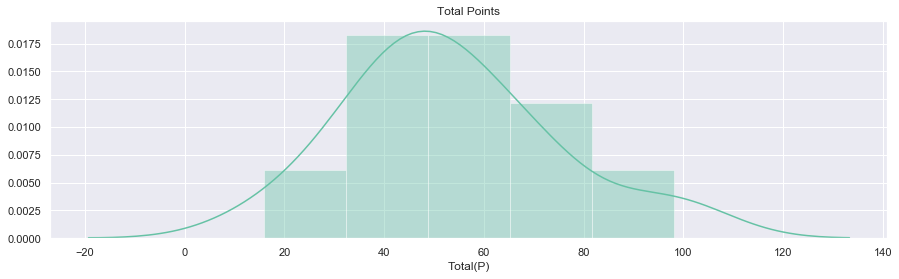

In [331]:
# distribution of total points
sns.distplot(total["Total(P)"])
plt.title("Total Points");

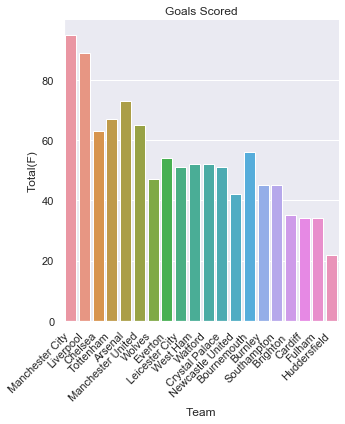

In [332]:
# bar plot of goals scored
goals_for = sns.catplot(x="Team", y="Total(F)", kind="bar", data=total.reset_index())
goals_for.set_xticklabels(rotation=45, horizontalalignment="right")
plt.title("Goals Scored");

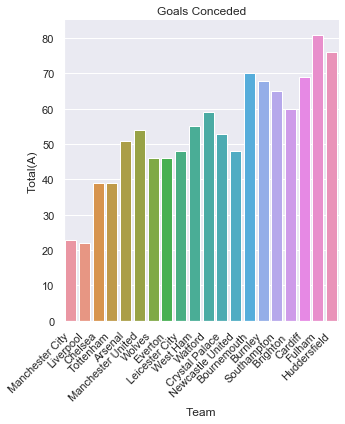

In [333]:
# bar plot of goals conceded
goals_for = sns.catplot(x="Team", y="Total(A)", kind="bar", data=total.reset_index())
goals_for.set_xticklabels(rotation=45, horizontalalignment="right")
plt.title("Goals Conceded");

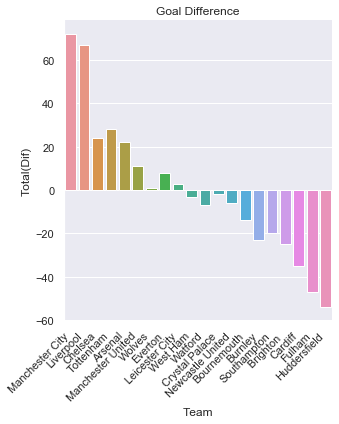

In [334]:
# bar plot of goal difference
goal_dif = sns.catplot(x="Team", y="Total(Dif)", kind="bar", data=total.reset_index())
goal_dif.set_xticklabels(rotation=45, horizontalalignment="right")
plt.title("Goal Difference");

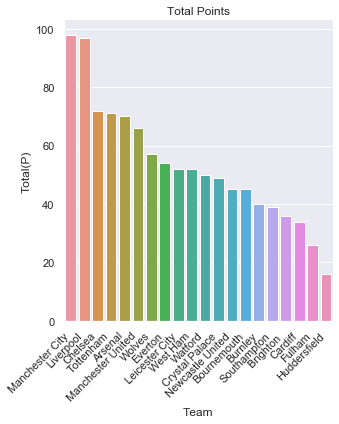

In [335]:
# bar plot of goals scored at home
goals_for = sns.catplot(x="Team", y="Total(P)", kind="bar", data=total.reset_index())
goals_for.set_xticklabels(rotation=45, horizontalalignment="right")
plt.title("Total Points");

## Home

In [336]:
# added new column with home goal difference
pl["Home(Dif)"] = pl["Home(F)"] - pl["Home(A)"]
# created league table based on home form
home = pl[["Home(F)", "Home(A)", "Home(Dif)", "Points(H)"]]
# sorted league table by points
home = home.sort_values(by = "Points(H)", ascending=False);
home

,Home(F),Home(A),Home(Dif),Points(H)
Team,,,,
Manchester City,57,12,45,54
Liverpool,55,10,45,53
Arsenal,42,16,26,45
Chelsea,39,12,27,42
Tottenham,34,16,18,38
Manchester United,33,25,8,36
Wolves,28,21,7,34
Everton,30,21,9,34
West Ham,32,27,5,31


In [337]:
# description of home stats
home.describe()

,Home(F),Home(A),Home(Dif),Points(H)
count,20.000000,20.000000,20.000000,20.000000
mean,29.800000,23.800000,6.000000,30.700000
std,11.542142,7.878017,18.381913,11.494163
min,10.000000,10.000000,-21.000000,9.000000
25%,23.500000,19.000000,-5.000000,23.000000
50%,27.500000,25.000000,4.500000,28.000000
75%,33.250000,28.500000,11.250000,36.500000
max,57.000000,38.000000,45.000000,54.000000


## Away

In [345]:
# added new column with away goal difference
pl["Away(Dif)"] = pl["Away(F)"] - pl["Away(A)"]
# created league table based on away form
away = pl[["Away(F)", "Away(A)", "Away(Dif)", "Points(A)"]]
# sorted league table by points
away = away.sort_values(by="Points(A)", ascending=False);
away

,Away(F),Away(A),Away(Dif),Points(A)
Team,,,,
Manchester City,38,11,27,44
Liverpool,34,12,22,44
Tottenham,33,23,10,33
Chelsea,24,27,-3,30
Manchester United,32,29,3,30
Crystal Palace,32,30,2,29
Leicester City,27,28,-1,25
Arsenal,31,35,-4,25
Watford,26,31,-5,23


In [346]:
# description of away stats
away.describe()

,Away(F),Away(A),Away(Dif),Points(A)
count,20.000000,20.000000,20.000000,20.000000
mean,23.800000,29.800000,-6.000000,22.750000
std,7.831112,9.225822,15.245362,10.361238
min,12.000000,11.000000,-33.000000,5.000000
25%,18.000000,25.000000,-16.250000,16.000000
50%,24.000000,29.500000,-5.000000,22.000000
75%,31.250000,35.000000,-0.250000,29.250000
max,38.000000,45.000000,27.000000,44.000000


## Home vs. Away

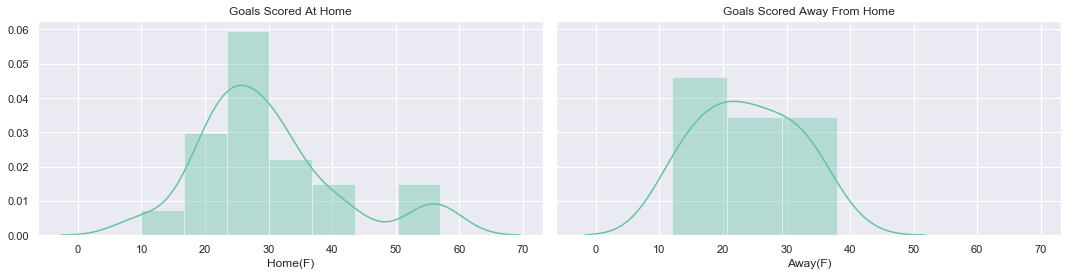

In [354]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals scored at home
sns.distplot(home["Home(F)"], ax=axes[0])
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Away(F)"], ax= axes[1])
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()



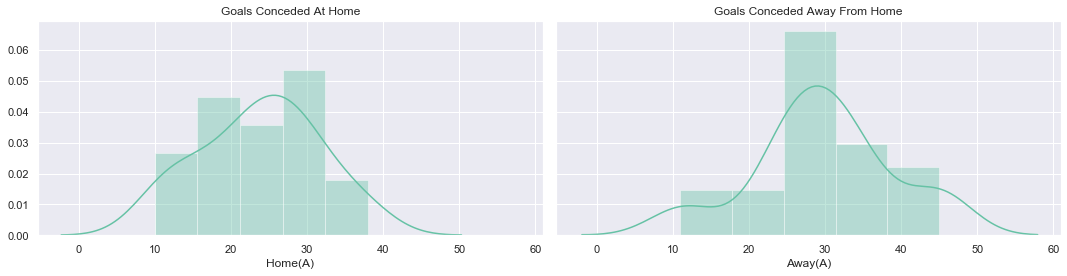

In [355]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals conceded at home
sns.distplot(home["Home(A)"], ax=axes[0])
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
sns.distplot(away["Away(A)"], ax= axes[1])
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()


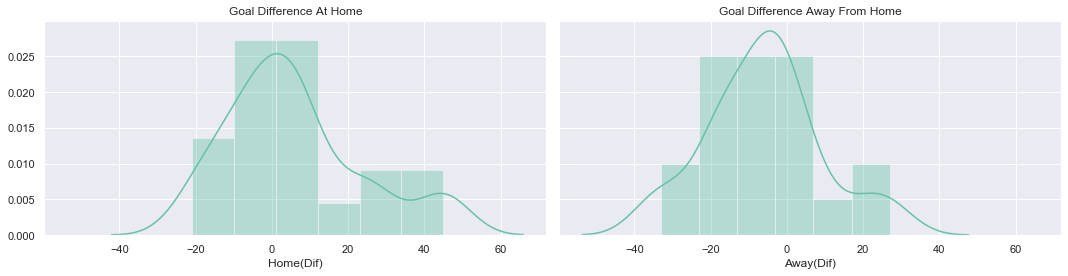

In [356]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals difference at home
sns.distplot(home["Home(Dif)"], ax=axes[0])
axes[0].set_title("Goal Difference At Home");

# distibution of goals difference away from home 
sns.distplot(away["Away(Dif)"], ax= axes[1])
axes[1].set_title("Goal Difference Away From Home");

plt.tight_layout()


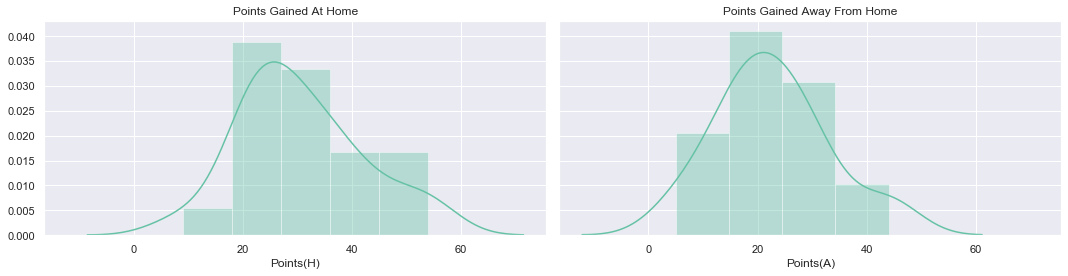

In [357]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals scored at home
sns.distplot(home["Points(H)"], ax=axes[0])
axes[0].set_title("Points Gained At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Points(A)"], ax= axes[1])
axes[1].set_title("Points Gained Away From Home");

plt.tight_layout()


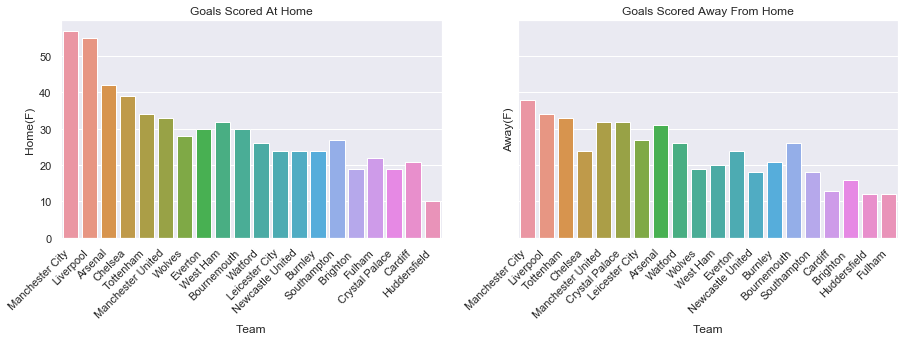

In [358]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals scored at home
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home 
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)




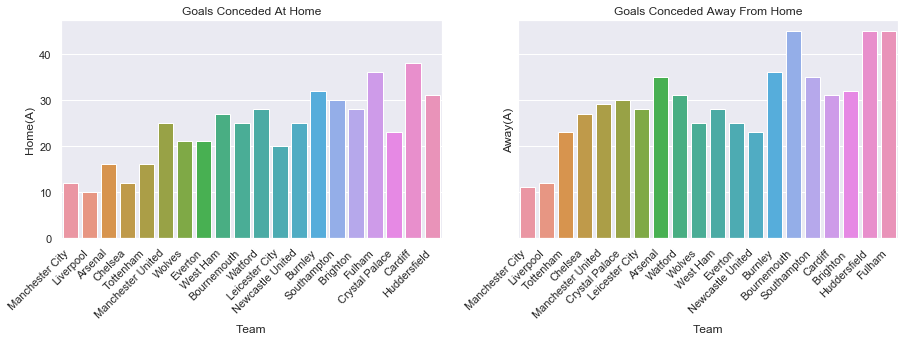

In [359]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)


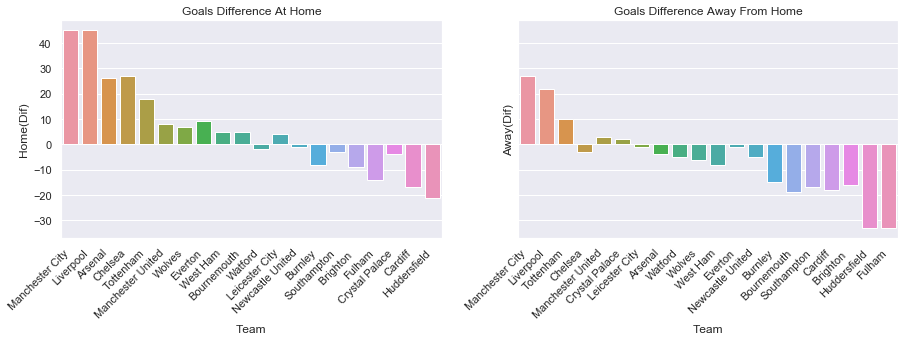

In [360]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Difference At Home");

# distibution of goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Difference Away From Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)


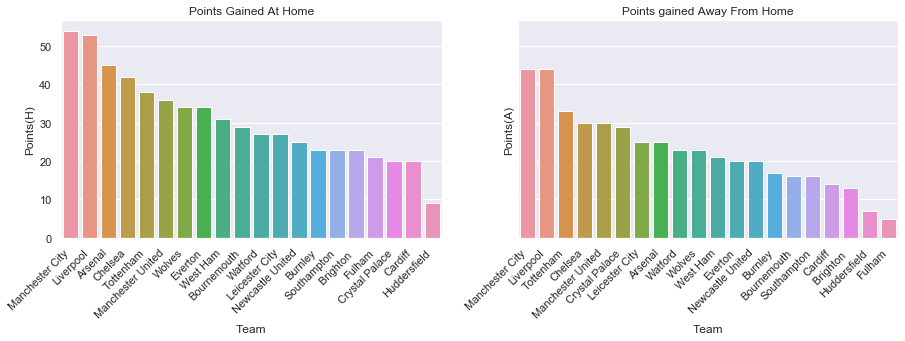

In [361]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of points gained at home
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Points Gained At Home");

# bar plot of points gained away from home 
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Points gained Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)
